**Projekt był realizowany przez 3 osobowy zespół.**
- Mateusz Godlewski, s19282
- Kacper Padarz, s18535
- Maciej Cichanowicz, s16691


## Setup

In [ ]:
!pip install demoji
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git
!pip install transformers==4.28.0
!pip install -U datasets
!wget https://nlp.stanford.edu/data/glove.6B.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 581.1 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JustAnotherArchivist/snscrape.git to /tmp/pip-req-build-hw4_jzzi
  Running command git clone --filter=blob:none --quiet https://github.com/JustAnotherArchivist/snscrape.git /tmp/pip-req-build-hw4_jzzi
  Resolved https://github.com/JustAnotherArchivist/snscrape.git to commit 786815dd05681e2421cd03aa9acf5ab5c773bce9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for snscrape: filename=snscrape-0.6.2.20230321.dev13+g786815d-py3-none-any.whl size=73302 sha256=870c9659a4a61b6aa0e788ca5bb81d4dd076d5b3c1a710aeee226067e09df41a
  Stored in director

In [ ]:
import re
import ast
import time
import nltk
import keras
import demoji
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import layers
from dateutil import rrule
from sklearn import metrics
from datasets import Dataset
from datetime import datetime
from keras import regularizers
from keras import backend as K
from google.colab import drive
import matplotlib.pyplot as plt
from datasets import load_metric
from nltk.corpus import stopwords
from transformers import pipeline
from keras.models import Sequential
from nltk.stem import WordNetLemmatizer
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import snscrape.modules.twitter as sntwitter
from sklearn.svm import SVC, LinearSVC, NuSVC
from keras.preprocessing.text import Tokenizer
from dateutil.relativedelta import relativedelta
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences, to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import RMSprop, Adam, AdamW
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
demoji.download_codes()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-3-477a9abbcfad>:4: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Etap 1 : data collection

In [ ]:
tweets = []

In [ ]:
# Pobieramy po 2000 tweetów z każdego miesiąca od lutego 2022 do kwietnia 2023
# aby tweety dotyczyły ogółu wydarzeń a nie konkretnego okresu

attributes_container = []

start_date = datetime(2022, 2, 1)
end_date = datetime(2023, 4, 15)

for dateSince in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
  dateUntil = dateSince+relativedelta(months=1)
  
  hashtag = f'#RussianUkrainianWar lang:en --since:{dateSince:%Y-%m-%d} until:{dateUntil:%Y-%m-%d}'
  query = f'{hashtag}'

  tss = sntwitter.TwitterSearchScraper(query)

  for i,tweet in enumerate(tss.get_items()):
    if i>2000:
        break
    if i%500 == 0:
      print(i)
    tweets.append([tweet.date,tweet.content])
  print(dateSince,' ',dateUntil)

In [ ]:
tweets_df = pd.DataFrame(tweets)

In [ ]:
tweets_df.rename(columns = {'0':'date', '1': 'rawContent'}, inplace = True)

In [ ]:
def clean_tweet_text(tweet):
    # Usuwamy URLe
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Usuwamy wzmianki (@username)
    tweet = re.sub(r'\@\w+', '', tweet)

    # Usuwamy hashtagi (#hashtag)
    tweet = re.sub(r'\#\w+', '', tweet)

    # Znajdujemy emoji i ich znaczenie
    emojis_and_meanings = demoji.findall(tweet)

    # Zamaiana emoji na ich znaczenie
    text_with_meanings = tweet
    for emoji, meaning in emojis_and_meanings.items():
        text_with_meanings = text_with_meanings.replace(emoji, meaning)
    tweet = text_with_meanings

    # Usunięcie znaków specjalnych, ewentualnych pozostałych emoji itd.
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)

    # Zamiana na małe znaki
    tweet = tweet.lower()

    # Stokenizowanie tekstu
    tweet_words = nltk.word_tokenize(tweet)

    # Usunięcie stop words
    stop_words = set(stopwords.words('english'))
    tweet_words = [word for word in tweet_words if word not in stop_words]

    # Lematyzacja
    lemmatizer = WordNetLemmatizer()
    tweet_words = [lemmatizer.lemmatize(word) for word in tweet_words]

    # Ponowne połączenie słów w jeden string
    cleaned_tweet = ' '.join(tweet_words)
    
    return cleaned_tweet

In [ ]:
tweets_df['tweetClean'] = tweets_df.apply(lambda row: clean_tweet_text(row['rawContent']), axis =1)

In [ ]:
# Usuwamy tweety, które po czyszczeniu zawierają mniej niż 4 słowa
text_len = []
for text in tweets_df.tweetClean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

tweets_df['text_len'] = text_len
tweets_df = tweets_df[tweets_df['text_len'] > 4]

In [ ]:
classifier = pipeline(task="zero-shot-classification", 
                      model="facebook/bart-large-mnli",
                      device=0) 

In [ ]:
sequences = tweets_df['tweetClean'].to_list()

candidate_labels = ["russia", "ukraine"]

hypothesis_template = "This text is pro {}."

hf_prediction = classifier(sequences, candidate_labels, hypothesis_template=hypothesis_template)

hf_prediction = pd.DataFrame(hf_prediction)

hf_prediction.head(5)

,sequence,labels,scores
0,completely eroded chance nuclear deal resource...,"[ukraine, russia]","[0.588821291923523, 0.41117870807647705]"
1,could create refugee crisis million people com...,"[ukraine, russia]","[0.8375899195671082, 0.16241014003753662]"
2,week going one reckoning eu battle hardened se...,"[russia, ukraine]","[0.5311044454574585, 0.4688955843448639]"
3,people understand mean mean willingness shoot ...,"[ukraine, russia]","[0.7181963920593262, 0.28180357813835144]"
4,russian son worth nothing russian military loo...,"[russia, ukraine]","[0.7692970037460327, 0.23070307075977325]"


In [ ]:
hf_prediction['labels'] = hf_prediction['labels'].apply(lambda x: x[0])
# Zbalansowanie danych, tak by tekstów proukraińskich i prorosyjskich było po równo
min_rows = hf_prediction['labels'].value_counts().min()
balanced_df = hf_prediction.groupby('labels').apply(lambda x: x.sample(min_rows)).reset_index(drop=True)

In [ ]:
y = hf_prediction['labels'].apply(lambda x: x[0])
y = balanced_df['labels']
y.replace('russia', 0, inplace=True)
y.replace('ukraine', 1, inplace=True)
labels = to_categorical(y, num_classes = 2)

In [ ]:
X = balanced_df['sequence']

## Etap 2 : CLASSIC ML

In [ ]:
vectorizer = TfidfVectorizer() 
tweets_tdidf = vectorizer.fit_transform(X)

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(tweets_tdidf, y, train_size=0.8, stratify=labels, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

### Logistic regression

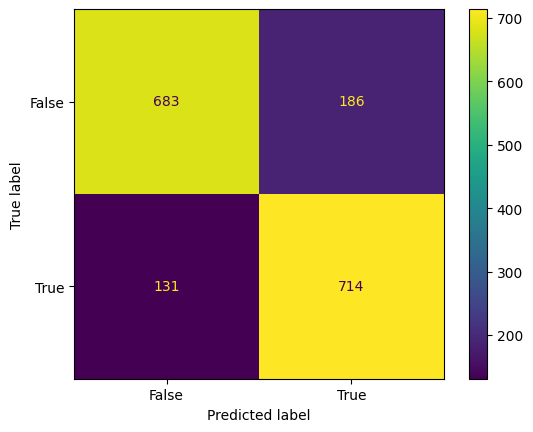

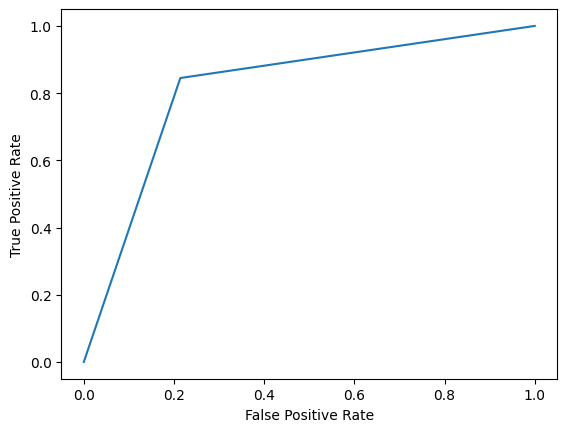

Test Score with logistic regression:  0.8150525087514586


In [ ]:
logistic_regression = LogisticRegression(C=1.0).fit(X_train, y_train)
score_LR = logistic_regression.score(X_test, y_test)
y_predict_LR = logistic_regression.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_predict_LR)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict_LR)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('Test Score with logistic regression: ', score_LR)

### LSVC

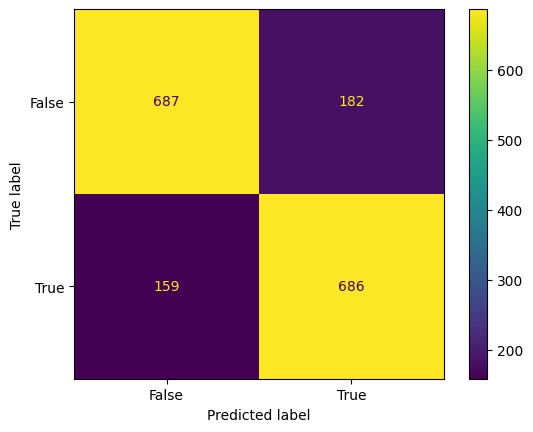

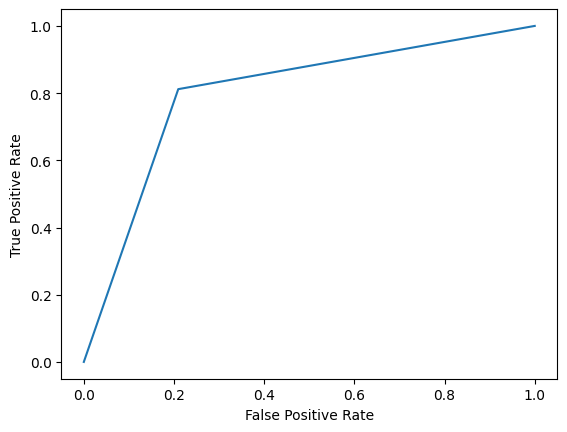

LSVC Accuracy:  0.8010501750291715


In [ ]:
LSVC = LinearSVC()
LSVC.fit(X_train,y_train)
y_predict_LSVC = LSVC.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_predict_LSVC)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict_LSVC)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("LSVC Accuracy: ", accuracy_score(y_test, y_predict_LSVC))

### MNB

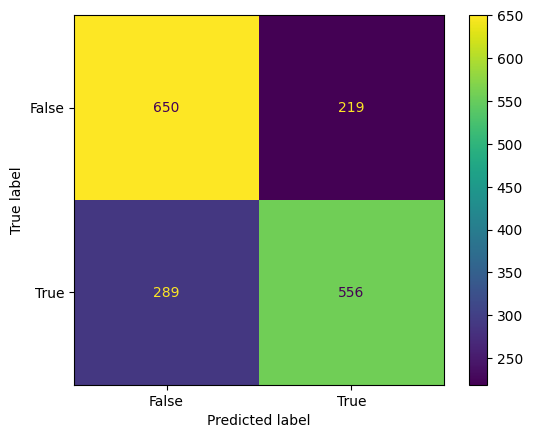

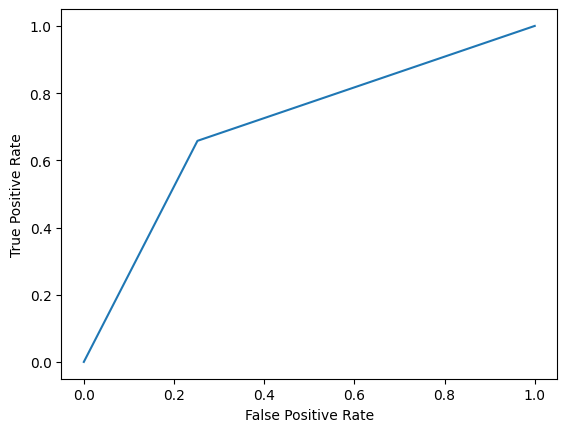

MNB Accuracy:  0.7036172695449242


In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train,y_train)
y_predict_MNB = MNB.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_predict_MNB)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict_MNB)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("MNB Accuracy: ", accuracy_score(y_test, y_predict_MNB))

## Etap 3 : NEURAL MODEL

In [ ]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(balanced_df.sequence)
sequences = tokenizer.texts_to_sequences(balanced_df.sequence)
tweets_pad = pad_sequences(sequences, maxlen = max_len)

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(tweets_pad, labels, test_size=0.2, random_state = 42, stratify=labels)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [ ]:
from zipfile import ZipFile
with ZipFile('glove.6B.zip', 'r') as z:
  z.extractall()
  
embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

In [ ]:
vocab = tokenizer.sequences_to_texts(balanced_df.sequence.to_list())
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
es = EarlyStopping(patience = 5, monitor='val_loss', verbose=1)

### Pierwszy model:

In [ ]:
modelA_checkpoint = ModelCheckpoint('best_modelA.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

modelA = Sequential()
modelA.add(layers.Input(shape=(max_len,), dtype='int32', name='review_input'))
modelA.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
modelA.add(layers.Bidirectional(layers.LSTM(40)))
modelA.add(layers.Flatten())
modelA.add(layers.Dense(units=64, activation='relu'))
modelA.add(layers.Dropout(0.5))
modelA.add(layers.Dense(units=32, activation='relu'))
modelA.add(layers.Dense(units=2, activation='softmax'))
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

historyA = modelA.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    verbose=True,
    validation_data=(X_valid, y_valid),
    callbacks = [es, modelA_checkpoint]
)

best_modelA = tf.keras.models.load_model('best_modelA.h5')
best_modelA.evaluate(X_test, y_test)

Epoch 1/25
429/429 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.7458
Epoch 1: val_loss improved from inf to 0.41678, saving model to best_modelA.h5
429/429 [==============================] - 40s 76ms/step - loss: 0.5270 - accuracy: 0.7458 - val_loss: 0.4168 - val_accuracy: 0.8279
Epoch 2/25
429/429 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8388
Epoch 2: val_loss improved from 0.41678 to 0.37862, saving model to best_modelA.h5
429/429 [==============================] - 10s 23ms/step - loss: 0.3904 - accuracy: 0.8388 - val_loss: 0.3786 - val_accuracy: 0.8541
Epoch 3/25
429/429 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8671
Epoch 3: val_loss improved from 0.37862 to 0.37836, saving model to best_modelA.h5
429/429 [==============================] - 10s 23ms/step - loss: 0.3203 - accuracy: 0.8671 - val_loss: 0.3784 - val_accuracy: 0.8483
Epoch 4/25
429/429 [==============================] - ETA: 0s - loss

[0.39480721950531006, 0.8366394639015198]

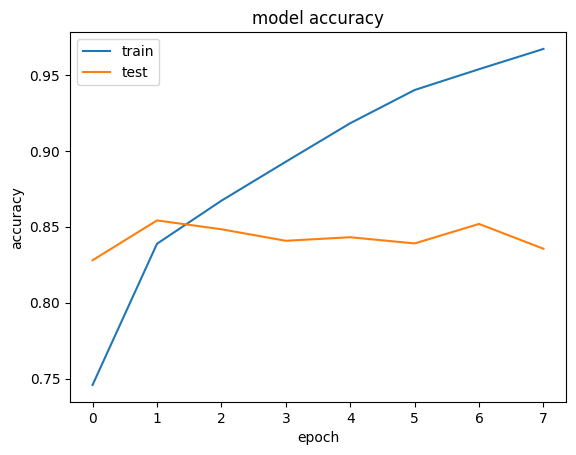

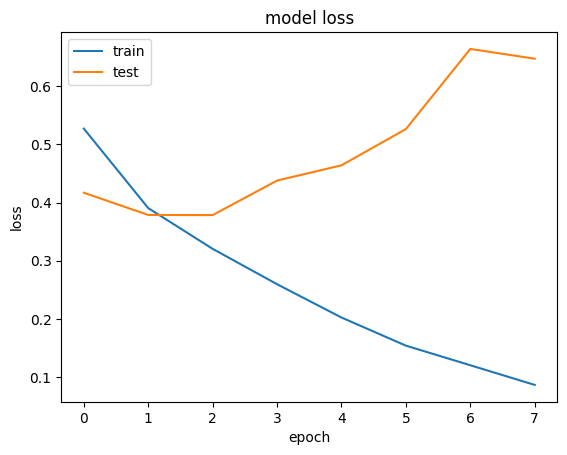

In [ ]:
plt.plot(historyA.history['accuracy'])
plt.plot(historyA.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Drugi model:

In [ ]:
modelB_checkpoint = ModelCheckpoint('best_modelB.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

modelB = Sequential()

modelB.add(layers.Input(shape=(max_len,), dtype='int32', name='review_input'))
modelB.add(layers.Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_len, trainable=True))
modelB.add(layers.LSTM(20))
modelB.add(layers.Flatten())
modelB.add(layers.Dense(units=256, activation='relu'))
modelB.add(layers.Dropout(0.25))
modelB.add(layers.Dense(units=128, activation='relu'))
modelB.add(layers.Dropout(0.8))
modelB.add(layers.Dense(units=64, activation='relu'))
modelB.add(layers.Dense(units=32, activation='relu'))
modelB.add(layers.Dense(units=2, activation='softmax'))
modelB.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

historyB = modelB.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    verbose=True,
    validation_data=(X_valid, y_valid),
    callbacks = [es, modelB_checkpoint]
)

best_modelB = tf.keras.models.load_model('best_modelB.h5')
best_modelB.evaluate(X_test, y_test)

Epoch 1/25
429/429 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.7286
Epoch 1: val_loss improved from inf to 0.42004, saving model to best_modelB.h5
429/429 [==============================] - 27s 54ms/step - loss: 0.5454 - accuracy: 0.7286 - val_loss: 0.4200 - val_accuracy: 0.8314
Epoch 2/25
429/429 [==============================] - ETA: 0s - loss: 0.3902 - accuracy: 0.8408
Epoch 2: val_loss improved from 0.42004 to 0.39531, saving model to best_modelB.h5
429/429 [==============================] - 6s 15ms/step - loss: 0.3902 - accuracy: 0.8408 - val_loss: 0.3953 - val_accuracy: 0.8489
Epoch 3/25
429/429 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8719
Epoch 3: val_loss did not improve from 0.39531
429/429 [==============================] - 7s 17ms/step - loss: 0.3224 - accuracy: 0.8719 - val_loss: 0.4013 - val_accuracy: 0.8372
Epoch 4/25
429/429 [==============================] - ETA: 0s - loss: 0.2548 - accuracy: 0.8965
Epoch 4: v

[0.40397194027900696, 0.8325554132461548]

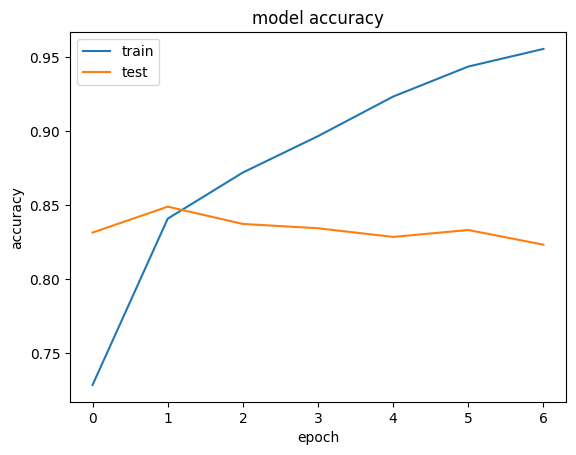

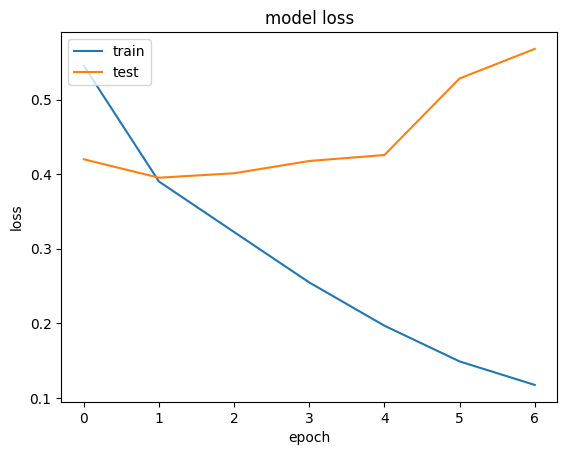

In [ ]:
plt.plot(historyB.history['accuracy'])
plt.plot(historyB.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Etap 4 : LANGUAGE MODEL

In [ ]:
df_merged = pd.concat([X,y], axis=1)

In [ ]:
df_merged.rename(columns = {'sequence':'text'}, inplace = True)
df_merged.rename(columns = {'labels':'label'}, inplace = True)

In [ ]:
dataset_ = Dataset.from_pandas(df_merged)
dataset = dataset_.train_test_split(0.1)

### DistilBERT

In [ ]:
model_checkpoint = 'distilbert-base-uncased'
batch_size = 128

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
test_ds = dataset['test'].map(process)

Map:   0%|          | 0/15426 [00:00<?, ? examples/s]

Map:   0%|          | 0/1714 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [ ]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 5,
    weight_decay = 0.03,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    logging_steps=10,
)

In [ ]:
metric = load_metric('glue', 'sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

<ipython-input-77-a6bf47ba013e>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', 'sst2')


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.371700,0.363522,0.856476
2,0.340100,0.333646,0.859393
3,0.272700,0.314806,0.871645
4,0.272600,0.313216,0.871645
5,0.248500,0.316466,0.875146


TrainOutput(global_step=605, training_loss=0.3243227781343066, metrics={'train_runtime': 325.2334, 'train_samples_per_second': 237.153, 'train_steps_per_second': 1.86, 'total_flos': 950846330495784.0, 'train_loss': 0.3243227781343066, 'epoch': 5.0})

### AlBERT

In [ ]:
model_checkpoint = 'albert-base-v2'
batch_size = 128

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
test_ds = dataset['test'].map(process)

Map:   0%|          | 0/15426 [00:00<?, ? examples/s]

Map:   0%|          | 0/1714 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

In [ ]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 6,
    weight_decay = 0.007,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    logging_steps=10
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.361600,0.376957,0.857643
2,0.337000,0.336717,0.868728
3,0.288700,0.322546,0.872812
4,0.265600,0.325532,0.873396
5,0.175700,0.333528,0.865811
6,0.143500,0.355480,0.871062


TrainOutput(global_step=726, training_loss=0.2847919044580013, metrics={'train_runtime': 784.0298, 'train_samples_per_second': 118.052, 'train_steps_per_second': 0.926, 'total_flos': 202532771689560.0, 'train_loss': 0.2847919044580013, 'epoch': 6.0})